In [24]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
import pandas as pd
import sklearn
import numpy as np
import glob
from mountaineer import Mountaineer
from gale import create_mapper, bootstrap_mapper_params

## Import Diabetes dataset

In [25]:
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv("./dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [26]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

## Train a neural network model with two hidden layers

In [27]:
batch_size = 16
num_epochs = 80
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [29]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [49]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.30855 | Acc: 87.615 | F1: 80.27622
Epoch 040: | Loss: 0.23999 | Acc: 90.385 | F1: 85.71296
Epoch 060: | Loss: 0.25312 | Acc: 90.192 | F1: 84.59839
Epoch 080: | Loss: 0.19705 | Acc: 90.885 | F1: 86.38622
Set to eval


In [48]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()

X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (146, 8)
Y_test of correct predictions shape: (146,)
Label in Y_test of correct predictions ratio: 
 [[ 0 98]
 [ 1 48]]


## Use the sigmoid function as the prediction probability function for Mapper

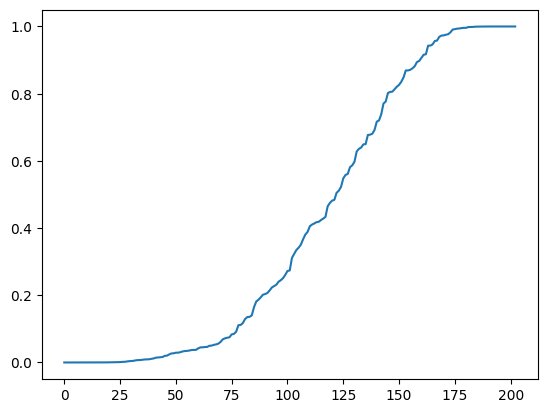

In [32]:
predictions = torch.sigmoid(model(X_test_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [33]:
print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [34]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]


Start integrated gradients for correct predictions with black_baseline
--- '0.10' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '0.60' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '1.10' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '1.05' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '1.06' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.14' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.21' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '1.28' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '1.24' seconds computation time ---
Start DeepSHAP for correct predic

In [35]:
#baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']

## Creating the mapper outputs

In [36]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
distances=[0.1,0.2,0.3,0.4,0.5]

function = np.array([np.squeeze(i) for i in predictions])

params_boots = {'original': bootstrap_mapper_params(X_test_tens.numpy(), function, resolutions, gains, distances, ci=0.95, n=100),
                'IG':       bootstrap_mapper_params(explanations['IG'][4], function, resolutions, gains, distances, ci=0.95, n=100),
                'DeepSHAP': bootstrap_mapper_params(explanations['DeepSHAP'][4], function, resolutions, gains, distances, ci=0.95, n=100),
                'DeepLIFT': bootstrap_mapper_params(explanations['DeepLIFT'][4], function, resolutions, gains, distances, ci=0.95, n=100)
                }

In [37]:
for mode in params_boots.keys():
    print(f"Params {mode}: {params_boots[mode]}")

Params original: {'stability': 0.020323574542999323, 'components': 3, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.5}
Params IG: {'stability': 0.01527225971221935, 'components': 4, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.3}
Params DeepSHAP: {'stability': 0.01527225971221935, 'components': 4, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.3}
Params DeepLIFT: {'stability': 0.01527225971221935, 'components': 4, 'resolution': 10, 'gain': 0.5, 'distance_threshold': 0.3}


In [38]:
mappers = { 'original': {'fixed_params': create_mapper(X_test_tens.numpy(), function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(X_test_tens.numpy(), function, resolution=params_boots['original']['resolution'], gain=params_boots['original']['gain'], dist_thresh=params_boots['original']['distance_threshold'])},

            'IG':       {'fixed_params': create_mapper(explanations['IG'][4], function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(explanations['IG'][4], function, resolution=params_boots['IG']['resolution'], gain=params_boots['IG']['gain'], dist_thresh=params_boots['IG']['distance_threshold']),
                        'boots_params_d': create_mapper(explanations['IG'][4], function, resolution=params_boots['DeepSHAP']['resolution'], gain=params_boots['DeepSHAP']['gain'], dist_thresh=params_boots['DeepSHAP']['distance_threshold'])},

            'DeepSHAP': {'fixed_params': create_mapper(explanations['DeepSHAP'][4], function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(explanations['DeepSHAP'][4], function, resolution=params_boots['DeepSHAP']['resolution'], gain=params_boots['DeepSHAP']['gain'], dist_thresh=params_boots['DeepSHAP']['distance_threshold'])},
                        
            'DeepLIFT': {'fixed_params': create_mapper(explanations['DeepLIFT'][4], function, resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42)),
                        'boots_params': create_mapper(explanations['DeepLIFT'][4], function, resolution=params_boots['DeepLIFT']['resolution'], gain=params_boots['DeepLIFT']['gain'], dist_thresh=params_boots['DeepLIFT']['distance_threshold'])}
        }

In [39]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:1920px !important; }</style>"))

In [40]:
#list of mapper outputs - minimum 2
mapper_outputs=[ mappers['original']['fixed_params'], mappers['IG']['fixed_params'], mappers['DeepSHAP']['fixed_params'], mappers['DeepLIFT']['fixed_params'],
                mappers['original']['boots_params'], mappers['IG']['boots_params'], mappers['DeepSHAP']['boots_params'], mappers['DeepLIFT']['boots_params']
                ]

explanation_vectors=[X_test_tens.numpy(), explanations['IG'][4], explanations['DeepSHAP'][4], explanations['DeepLIFT'][4],
                     X_test_tens.numpy(), explanations['IG'][4], explanations['IG'][4], explanations['DeepSHAP'][4], explanations['DeepLIFT'][4]
                    ]
explanation_list=[]
for expl in explanation_vectors:
    explanation_list.append(expl.tolist())

expl_labels=['Data_FP', 'IG_FP_GB', 'DS_FP_GB', 'DL_FP_GB', 'Data_BP', 'IG_BP_GB', 'DS_BP_GB', 'DL_BP_GB']
class_labels = {1:'Diabetic', 0:"Non Diabetic" }
#array of what we want the values to be colored by by default(In this case we are simply passing the lens - ie. Prediction Probabilities)
predicted_prob = np.array([np.squeeze(i) for i in predictions])

#column names of the dataframe
column_names= np.array(X.columns)


In [41]:
#visualize
mnt = Mountaineer()
mnt.visualize(X_test.to_numpy(),y_test.to_numpy(), predicted_prob, explanation_list, mapper_outputs, column_names, expl_labels, class_labels) #Projection method- 'UMAP' or 'TSNE'

In [42]:
#mean of explanation attributions for every feature zero baseline Integrated Gradient
np.max(explanation_vectors[0], axis=0)

array([ 17.   , 196.   , 104.   ,  54.   , 846.   ,  49.7  ,   1.731,
        81.   ], dtype=float32)

In [43]:
#means of explanation attributions for every feature for max distance baseline Integrated Gradients
np.mean(explanation_vectors[1], axis=0)

array([-0.02510728,  0.78238636,  5.3435664 ,  0.7728419 ,  1.6428316 ,
        4.8858957 ,  0.06492575,  2.8078883 ], dtype=float32)

In [44]:
#mean of explanation attributions for every feature zero baseline Integrated Gradient
np.median(explanation_vectors[0], axis=0)

array([  3.   , 117.   ,  72.   ,  23.   ,  48.   ,  31.2  ,   0.361,
        31.   ], dtype=float32)

In [45]:
np.min(explanation_vectors[0], axis=0)

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.085, 21.   ],
      dtype=float32)

In [ ]:
X_test.describe()

In [55]:
b

{'nodes': defaultdict(list,
             {'cube0_cluster0': [0,
               1,
               2,
               4,
               5,
               6,
               13,
               17,
               18,
               21,
               22,
               23,
               24,
               26,
               28,
               30,
               31,
               32,
               39,
               42,
               44,
               46,
               49,
               50,
               52,
               53,
               55,
               57,
               58,
               59,
               60,
               62,
               66,
               67,
               68,
               71,
               74,
               75,
               82,
               84,
               86,
               87,
               88,
               96,
               97,
               99,
               102,
               104,
               112,
               114,
      